Nom 1:

Nom 2: 

# Repte 5: Gat o gos?

## Enunciat

En aquest repte crearem una **Xarxa Neuronal Convolucional** capaç de dir si una imatge correspon a la d'un gat o a la d'un gos.
Per poder fer això disposem d'un dataset format per 2000 fotos de gats i 2000 fotos de gossos. Aquest dataset es troba en [aquesta url](https://drive.google.com/file/d/1akESKTtn26-jiZGwMF1sVlDOMn8uQACu/view?usp=sharing).

### Pregunta 1
De quin tipus de problema es tracta?

In [13]:
# Descarrega el dataset. Aquest fitxer és un zip que pots descomprimir amb la llibreria zipfile
from zipfile import ZipFile
# Importem les llibreries necessàries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
import visualkeras
import gdown
import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request

In [3]:
# Descarreguem dataset
url = "https://drive.google.com/u/3/uc?id=1akESKTtn26-jiZGwMF1sVlDOMn8uQACu&export=download"
output = "dataset.zip"
gdown.download(url, output, quiet=False)
# Descomprimim
import shutil
shutil.unpack_archive("dataset.zip", "tmp")

Downloading...
From: https://drive.google.com/u/3/uc?id=1akESKTtn26-jiZGwMF1sVlDOMn8uQACu&export=download
To: C:\Users\User\Documents\GitHub\PracticasIABigData\IA_RedNeuronal\repte5Gat y Gos\dataset.zip
100%|██████████| 91.0M/91.0M [00:07<00:00, 11.5MB/s]


In [4]:
# Defineix les variables train_dir, validation_dir, test_dir amb el path de
# cada un dels directoris que contenen les imatges corresponents
train_dir = os.path.join('./tmp/cats_and_dogs_small/train/')
validation_dir = os.path.join('./tmp/cats_and_dogs_small/validation/')
test_dir = os.path.join('./tmp/cats_and_dogs_small/test/')

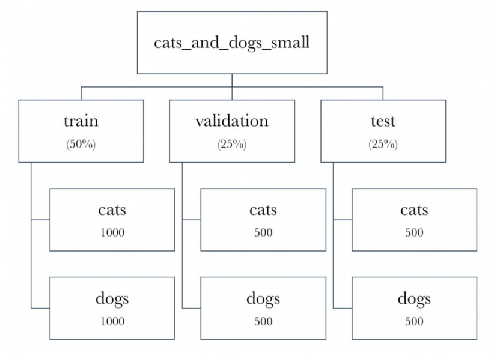

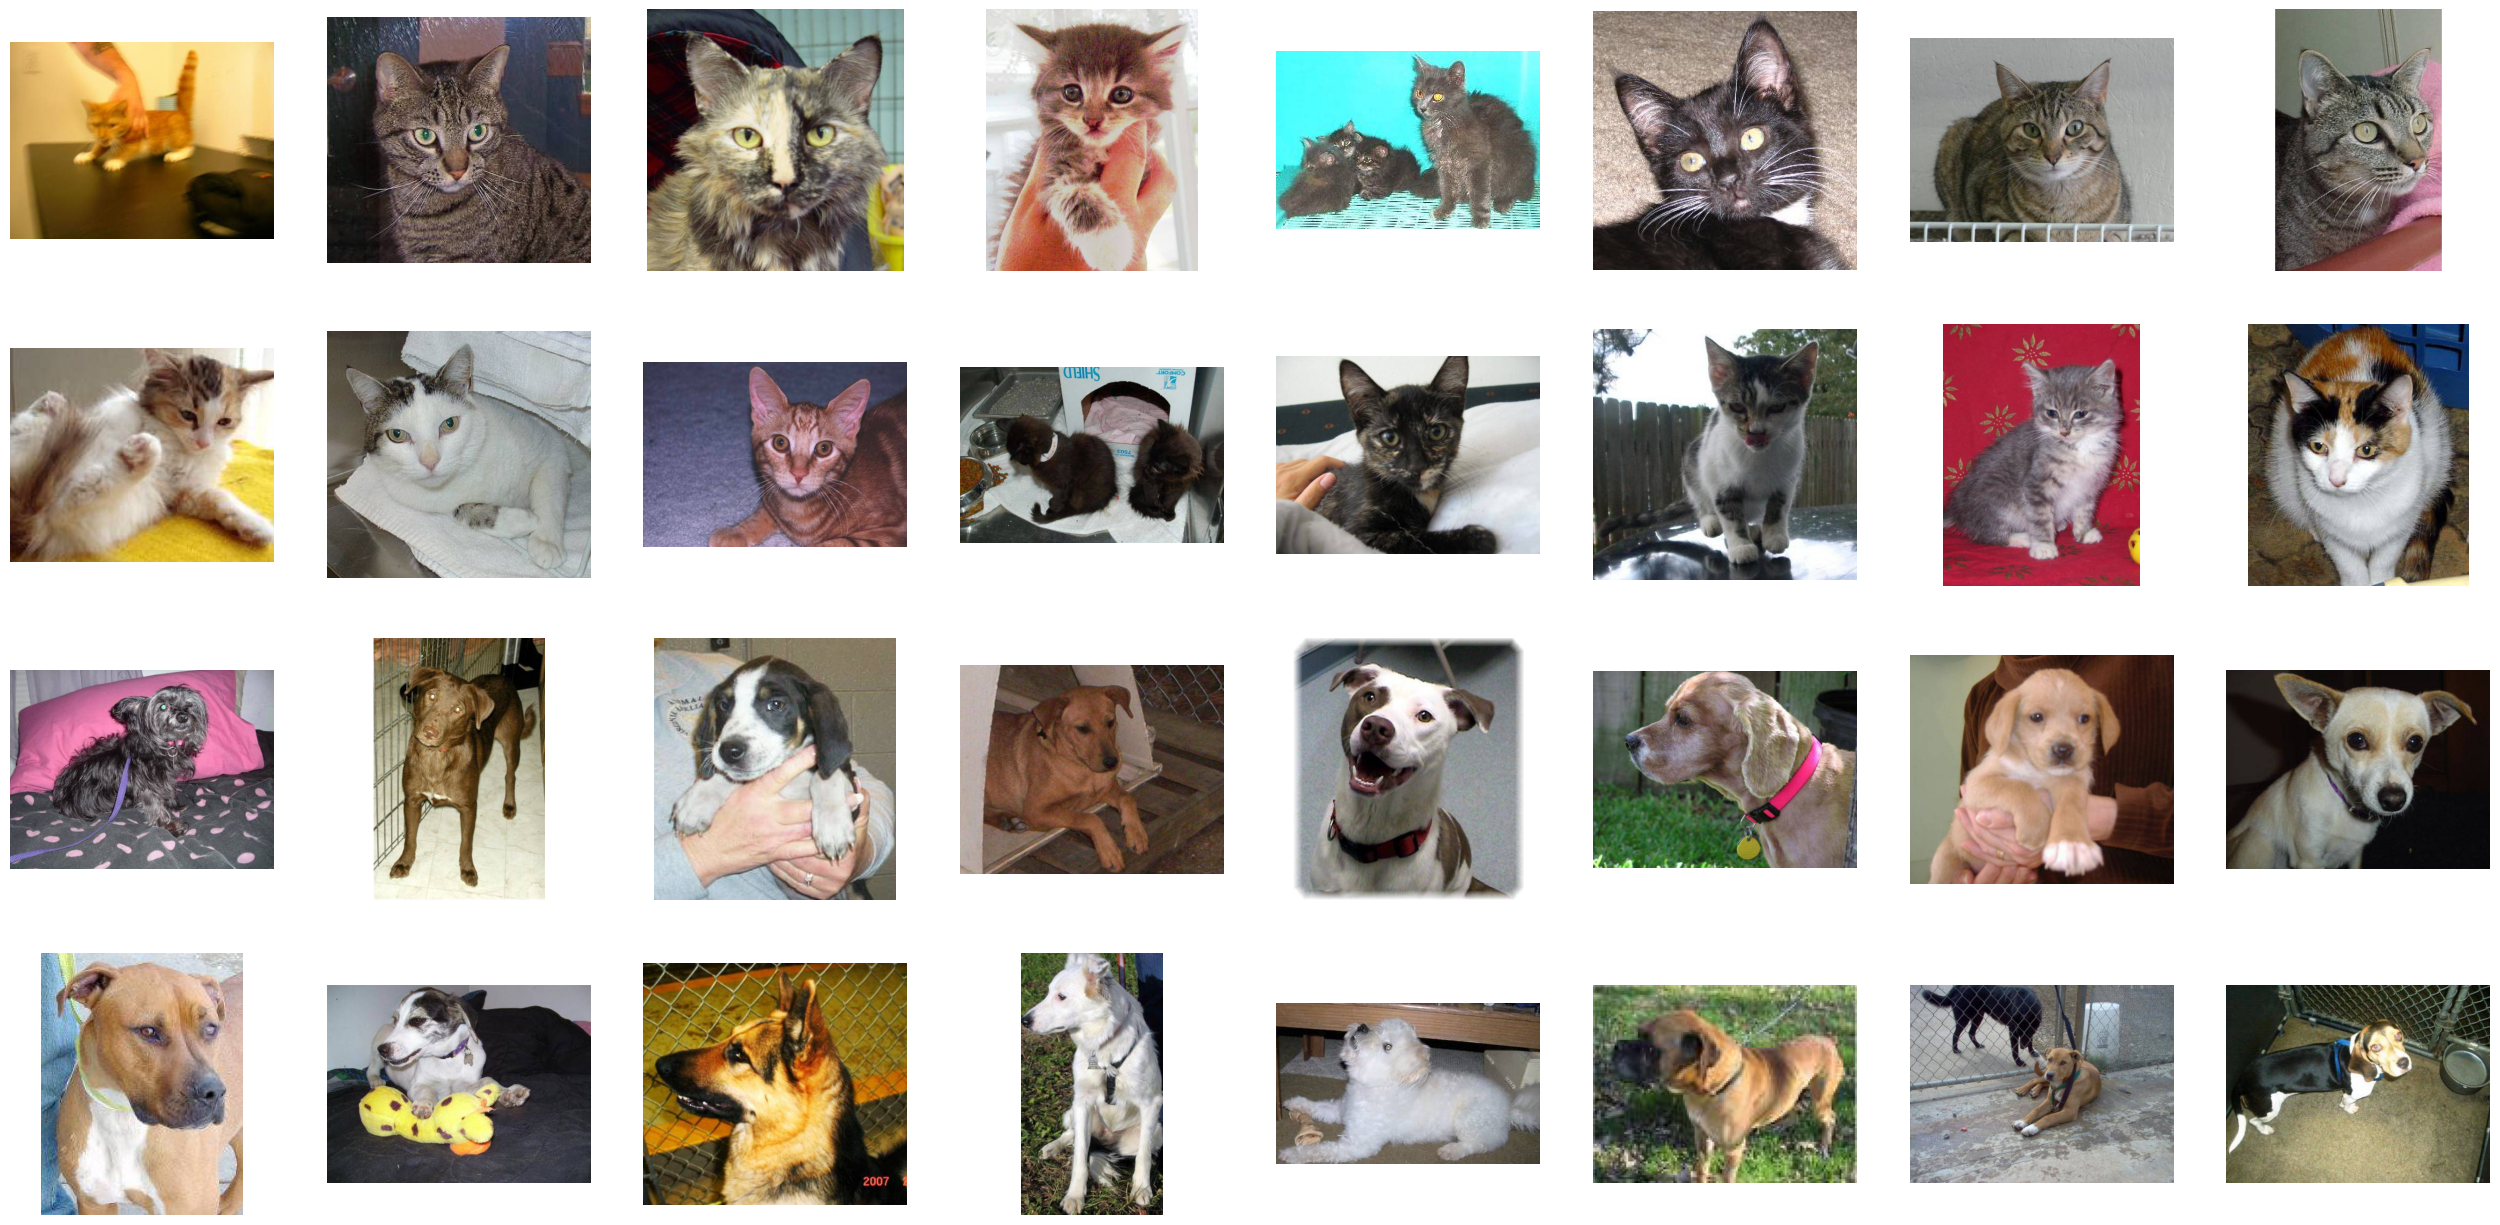

In [5]:
# Mostra les imatges de 16 gats i 16 gossos en matrius de 4x4
train_cats_dir = os.path.join('./tmp/cats_and_dogs_small/train/cats/')
train_dogs_dir = os.path.join('./tmp/cats_and_dogs_small/train/dogs/')
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
fig = plt.gcf().set_size_inches(32,32)

next_cat_pix = [os.path.join(train_cats_dir,fname) for fname in train_cats_fnames[0:16]]
next_dog_pix = [os.path.join(train_dogs_dir,fname) for fname in train_dogs_fnames[0:16]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(8, 8, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show() 


### Pregunta 2
Quàntes neurones tindrem a la capa de sortida?

In [6]:
# Degut a la complexitat del problema i a la mida de les imatges necessitarem una xarxa amb més capes. Això ens
# serveix per augmentar la capacitat del model i per reduïr encara més la mida del mapa de característiques abans
# d'arribar a la capa final. 
#
# Crea una xarxa neuronal amb 4 capes convolucionals + MaxPooling de 32, 64, 128 i 128 filtres respectivament i
# de mida 3x3 (Conv) i 2x2 (MaxP). Abans de la capa de sortida tindrem una capa densa de 512 neurones. L'entrada
# al nostre model serà de 150x150x3, farem servir imatges a color de 150x150 pixels i cada pixel necessita 3 números
# per poder codificar la profunditat de color en RGB.
# Observa amb el mètode summary com els mapes de característiques van reduïnt la seva mida a mesura que avancen
# al llarg de les capes de la xarxa neuronal.

model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,activation='relu'),

    tf.keras.layers.Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

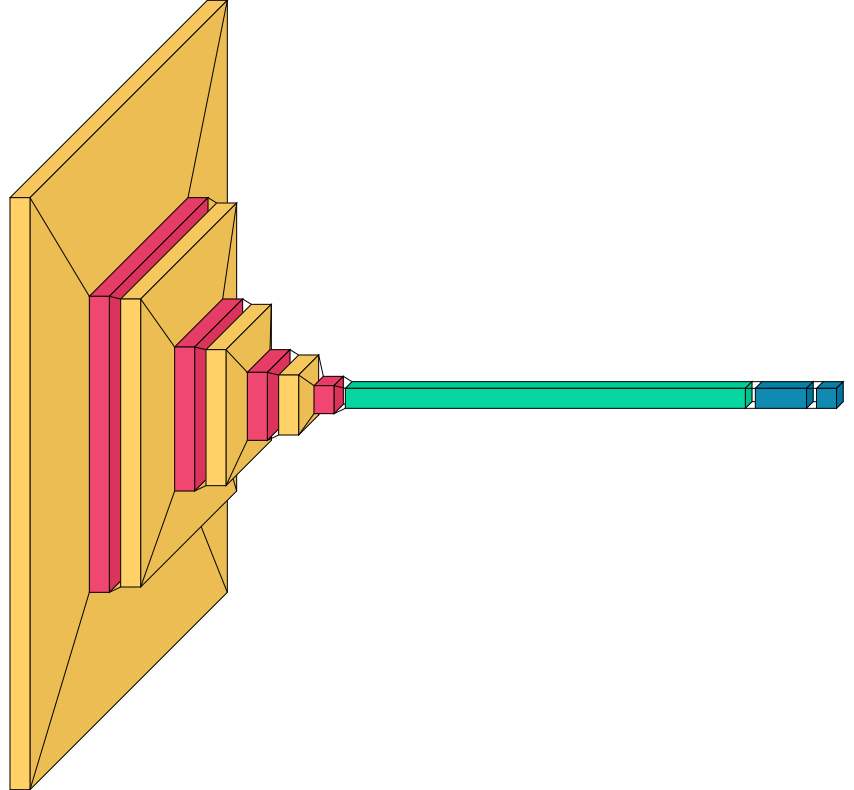

In [7]:
visualkeras.layered_view(model)

In [8]:
# Compil·la el model amb un optimitzador RMSprop amb un learning rate de 0,0001
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001), metrics = ['accuracy'])

In [16]:
# El dataset són imatges de diferents mides i amb pixels RGB compresos entre 0 i 255. Per poder
# realitzar l'entrenament necessitem imatges de 150x150 pixels i amb els valors RGB normalitzats
# entre 0 i 1.
#
# Pots realitzar aquesta operació fent servir ImageDataGenerator i aprofitar la jerarquia de directoris
# per definir la classe de cada una de les imatges.
#
# Exemple:
#
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(150, 150))     
#
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                            batch_size=20,
                                                            class_mode  = 'binary',
                                                            target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# Realitza l'entrenament del model incolent les dades de validació, amb 50 epochs i iguala la sortida
# a la variable "history"

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch=100, epochs=50, validation_steps=50, verbose=2)


Epoch 1/50
100/100 - 105s - loss: 0.6908 - accuracy: 0.5455 - val_loss: 0.6715 - val_accuracy: 0.5900 - 105s/epoch - 1s/step
Epoch 2/50
100/100 - 96s - loss: 0.6541 - accuracy: 0.6225 - val_loss: 0.6651 - val_accuracy: 0.5930 - 96s/epoch - 958ms/step
Epoch 3/50
100/100 - 84s - loss: 0.6039 - accuracy: 0.6760 - val_loss: 0.6889 - val_accuracy: 0.5950 - 84s/epoch - 845ms/step
Epoch 4/50
100/100 - 88s - loss: 0.5668 - accuracy: 0.7120 - val_loss: 0.5839 - val_accuracy: 0.6890 - 88s/epoch - 876ms/step
Epoch 5/50
100/100 - 92s - loss: 0.5320 - accuracy: 0.7375 - val_loss: 0.5819 - val_accuracy: 0.6830 - 92s/epoch - 917ms/step
Epoch 6/50
100/100 - 99s - loss: 0.4959 - accuracy: 0.7595 - val_loss: 0.5795 - val_accuracy: 0.6930 - 99s/epoch - 989ms/step
Epoch 7/50
100/100 - 100s - loss: 0.4702 - accuracy: 0.7765 - val_loss: 0.5758 - val_accuracy: 0.6860 - 100s/epoch - 998ms/step
Epoch 8/50
100/100 - 97s - loss: 0.4364 - accuracy: 0.7905 - val_loss: 0.5670 - val_accuracy: 0.7120 - 97s/epoch - 97

KeyboardInterrupt: 

### Pregunta 3
Quina és la precisió amb les dades d'entrenament? I amb les dades de validació?

Una diferència gran entre aquestes dues precisions ens podria estar indicant que s'ha produït sobreentrenament (overfitting).

In [ ]:
# Fent servir la variable history, mostra un gràfic amb l'evolució de precisió i l'error 
# de les dades d'entrenament i les dades de validació

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

A les gràfiques podem veure com les linies de la precisió de les dades d'entrenament i de validació es separen aproximadament a partir de l'epoch 5. A la gràfica de l'error, podem observar que mentre amb les dades d'entrenament l'error continua baixant, amb les dades de validació l'error s'estanca.

Això ens està indicant que a partir de aquest moment comença l'overfitting i el model ja no està millorant. És entrenament inútil.

La xarxa treballa bé amb les imatges amb les que ha estat entrenada però el seu rendiment baixa quan ha de fer prediccions amb imatges que no ha vist mai.

Si el resultat és satisfactori podriem aturar l'entrenement en aquest punt i quedar-nos amb el model obtingut. En cas contrari, hauríem de millorar el model o millorar el dataset.

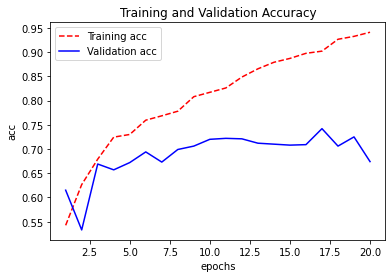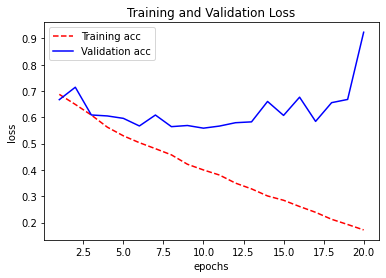

In [ ]:
# Crea una miniapp amb un botó que ens permeti escollir una imatge del nostre ordinador,
# mostri aquesta imatge després d'adaptarla i comprobi si es tracta d'un gat o d'un gos.
#
# Després prova amb diferents imatges de gats i gossos obtingudes d'internet o de fotos
# realitzades a la vida real. Si tens mascota és una bona oportunitat per fer proves.
